<a href="https://colab.research.google.com/github/narhelmi/Hyperparameter_optimization_narges/blob/main/Hyperparameter_optimization1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91353    0 91353    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
Archive:  wine+quality.zip
  inflating: winequality-red.csv     
  inflating: winequality-white.csv   
  inflating: winequality.names       
sample_data  winequality.names	winequality-red.csv  winequality-white.csv  wine+quality.zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulf

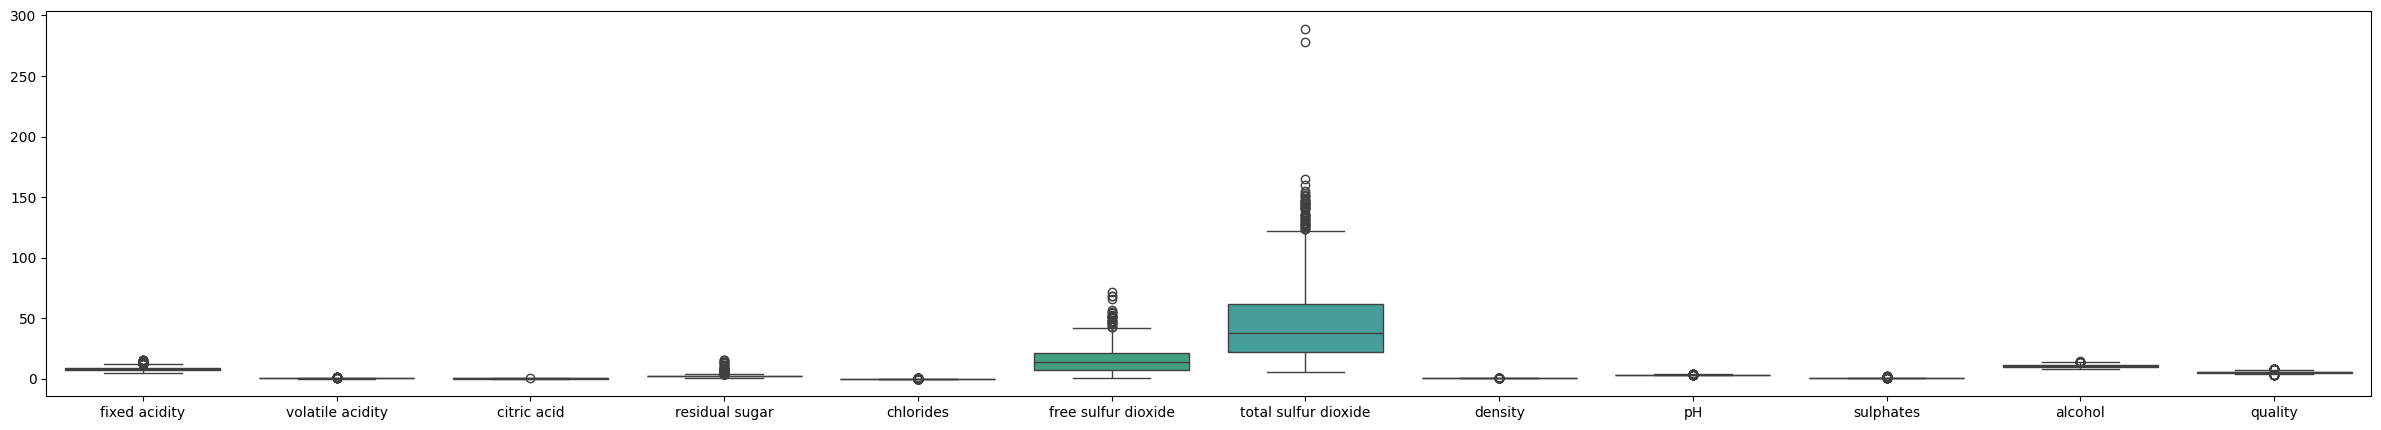

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint, loguniform

# Download dataset
!curl https://archive.ics.uci.edu/static/public/186/wine+quality.zip -O -J -L && unzip -o wine+quality.zip
!ls

# Load the dataset
path = './winequality-red.csv'
df = pd.read_csv(path, delimiter=';')

# Display dataset
print(df.info())
print(df.sample())


plt.figure(figsize=(30, 5))
sns.boxplot(data=df)
plt.show()

# Data preprocessing
X = df.drop('quality', axis=1)
Y = df['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [10]:
# Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy before Hyperparameter: {accuracy}')

# Define hyperparameter search space
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 100),
    'min_samples_split': randint(2, 100),
    'min_samples_leaf': randint(1, 4)
}

# RandomizedSearchCV
def evaluate_random_forest(model, param_distributions, n_iter=20, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, n_iter + 1),
        'accuracy': results['mean_test_score'],
        'max_depth': results['param_max_depth'],
        'min_samples_split': results['param_min_samples_split'],
        'min_samples_leaf': results['param_min_samples_leaf'],
        'n_estimators': results['param_n_estimators']
    })

    return accuracy, random_search.best_params_, results_df

# Evaluate Random Forest
tuned_accuracy, best_params, results_df = evaluate_random_forest(model, param_distributions, n_iter=20)

# Display the results
print(results_df)
best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for RandomForest: {best_iter}")

Random Forest Accuracy before Hyperparameter: 0.65
    iter  accuracy max_depth min_samples_split min_samples_leaf n_estimators
0      1  0.663061        54                16                1          206
1      2  0.660711        74                22                1          714
2      3  0.630218        85                76                3          558
3      4  0.649761        90                25                1          230
4      5  0.692770        24                 3                1          443
5      6  0.689632        32                 3                2          291
6      7  0.655248        62                34                1          559
7      8  0.624740        60                90                2          660
8      9  0.643511        93                43                3          575
9     10  0.630999        62                63                3          786
10    11  0.634917        64                56                3          343
11    12  0.692770       

In [13]:
# SVM model
model = SVC(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy before hyperparameter: {accuracy}')

# Define hyperparameter
param_distributions = {
    'C': loguniform(1, 1e2),
    'gamma': loguniform(1e-3, 1e0)
}

# RandomizedSearchCV
def evaluate_svm(model, param_distributions, n_iter=100, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, len(results['mean_test_score']) + 1),
        'accuracy': results['mean_test_score'],
        'C': results['param_C'],
        'gamma': results['param_gamma'],
    })

    return accuracy, random_search.best_params_, results_df
# Evaluate SVM
tuned_accuracy, best_params, results_df = evaluate_svm(model, param_distributions, n_iter=100)

# Display the results
print(results_df)
best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for SVM: {best_iter}")

SVM Accuracy before hyperparameter: 0.603125
    iter  accuracy          C     gamma
0      1  0.643508   5.611516  0.711448
1      2  0.624755  29.106359  0.062514
2      3  0.579418   2.051338  0.002938
3      4  0.646627   1.306674  0.396761
4      5  0.623968  15.930523  0.133112
..   ...       ...        ...       ...
95    96  0.653658   1.535343   0.49164
96    97  0.614589  63.217325  0.079306
97    98  0.589568   4.764964  0.011159
98    99  0.630999  28.308141  0.491282
99   100  0.609093  59.452873  0.218588

[100 rows x 4 columns]
Best hyperparameters for SVM: iter              17
accuracy    0.656011
C           1.349283
gamma       0.702517
Name: 16, dtype: object


In [14]:
# Gradient Boosting Model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Gradient Boosting  model Accuracy before hyperparameter: {accuracy}')

# Define hyperparameter
param_distributions = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.9),
    'max_depth': randint(3, 10),
}

# RandomizedSearchCV
def evaluate_gb(model, param_distributions, n_iter=20, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, len(results['mean_test_score']) + 1),
        'accuracy': results['mean_test_score'],
        'n_estimators': results['param_n_estimators'],
        'learning_rate': results['param_learning_rate'],
        'max_depth': results['param_max_depth'],
    })

    return accuracy, random_search.best_params_, results_df

# Evaluate
tuned_accuracy, best_params, results_df = evaluate_gb(model, param_distributions, n_iter=20)

# Display
print(results_df)
best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for GB: {best_iter}")

Gradient Boosting  model Accuracy before hyperparameter: 0.646875
    iter  accuracy n_estimators learning_rate max_depth
0      1  0.670885          114      0.347086         7
1      2  0.647420          120      0.668795         7
2      3  0.671651          174      0.150417         5
3      4  0.658361          199      0.423324         7
4      5  0.668526          249       0.13858         5
5      6  0.675551          257       0.06077         6
6      7  0.677914          120      0.201105         6
7      8  0.663042          121      0.565733         4
8      9  0.626314          148       0.01636         3
9     10  0.663839          269      0.482297         9
10    11  0.672433          114      0.051999         6
11    12  0.656808          289      0.420463         9
12    13  0.663839          163      0.189706         9
13    14  0.659908          150      0.430087         7
14    15  0.645824          266      0.622277         3
15    16  0.633346          159      0

In [16]:
# Deciosn Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Decision Tree Model Accuracy before Hyperparameter: {accuracy}')

# hyperparameter
param_distributions = {
   'max_depth': randint(3, 20),
    'min_samples_split': randint(3, 20),
    'min_samples_leaf': randint(3, 10)
}

# RandomizedSearchCV
def evaluate_dt (model, param_distributions, n_iter=100, cv=5):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        error_score='raise',
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results = random_search.cv_results_
    results_df = pd.DataFrame({
        'iter': range(1, len(results['mean_test_score']) + 1),
        'accuracy': results['mean_test_score'],
        'max_depth': results['param_max_depth'],
        'min_samples_split': results['param_min_samples_split'],
        'min_samples_leaf': results['param_min_samples_leaf'],
    })

    return accuracy, random_search.best_params_, results_df

# Evaluate
tuned_accuracy, best_params, results_df = evaluate_dt (model, param_distributions, n_iter=100)

# Display the results
print(results_df)
best_iter = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best hyperparameters for dt: {best_iter}")

Decision Tree Model Accuracy before Hyperparameter: 0.5625
    iter  accuracy max_depth min_samples_split min_samples_leaf
0      1  0.572328         9                17                6
1      2  0.578603        13                 9                7
2      3  0.551982        13                 6                5
3      4  0.560576        10                 4                5
4      5  0.584069        14                 8                8
..   ...       ...       ...               ...              ...
95    96  0.570815         3                 3                6
96    97  0.584072         5                12                4
97    98  0.587197         5                17                8
98    99  0.598925         4                12                9
99   100  0.595009         4                19                4

[100 rows x 5 columns]
Best hyperparameters for dt: iter                       99
accuracy             0.598925
max_depth                   4
min_samples_split          12


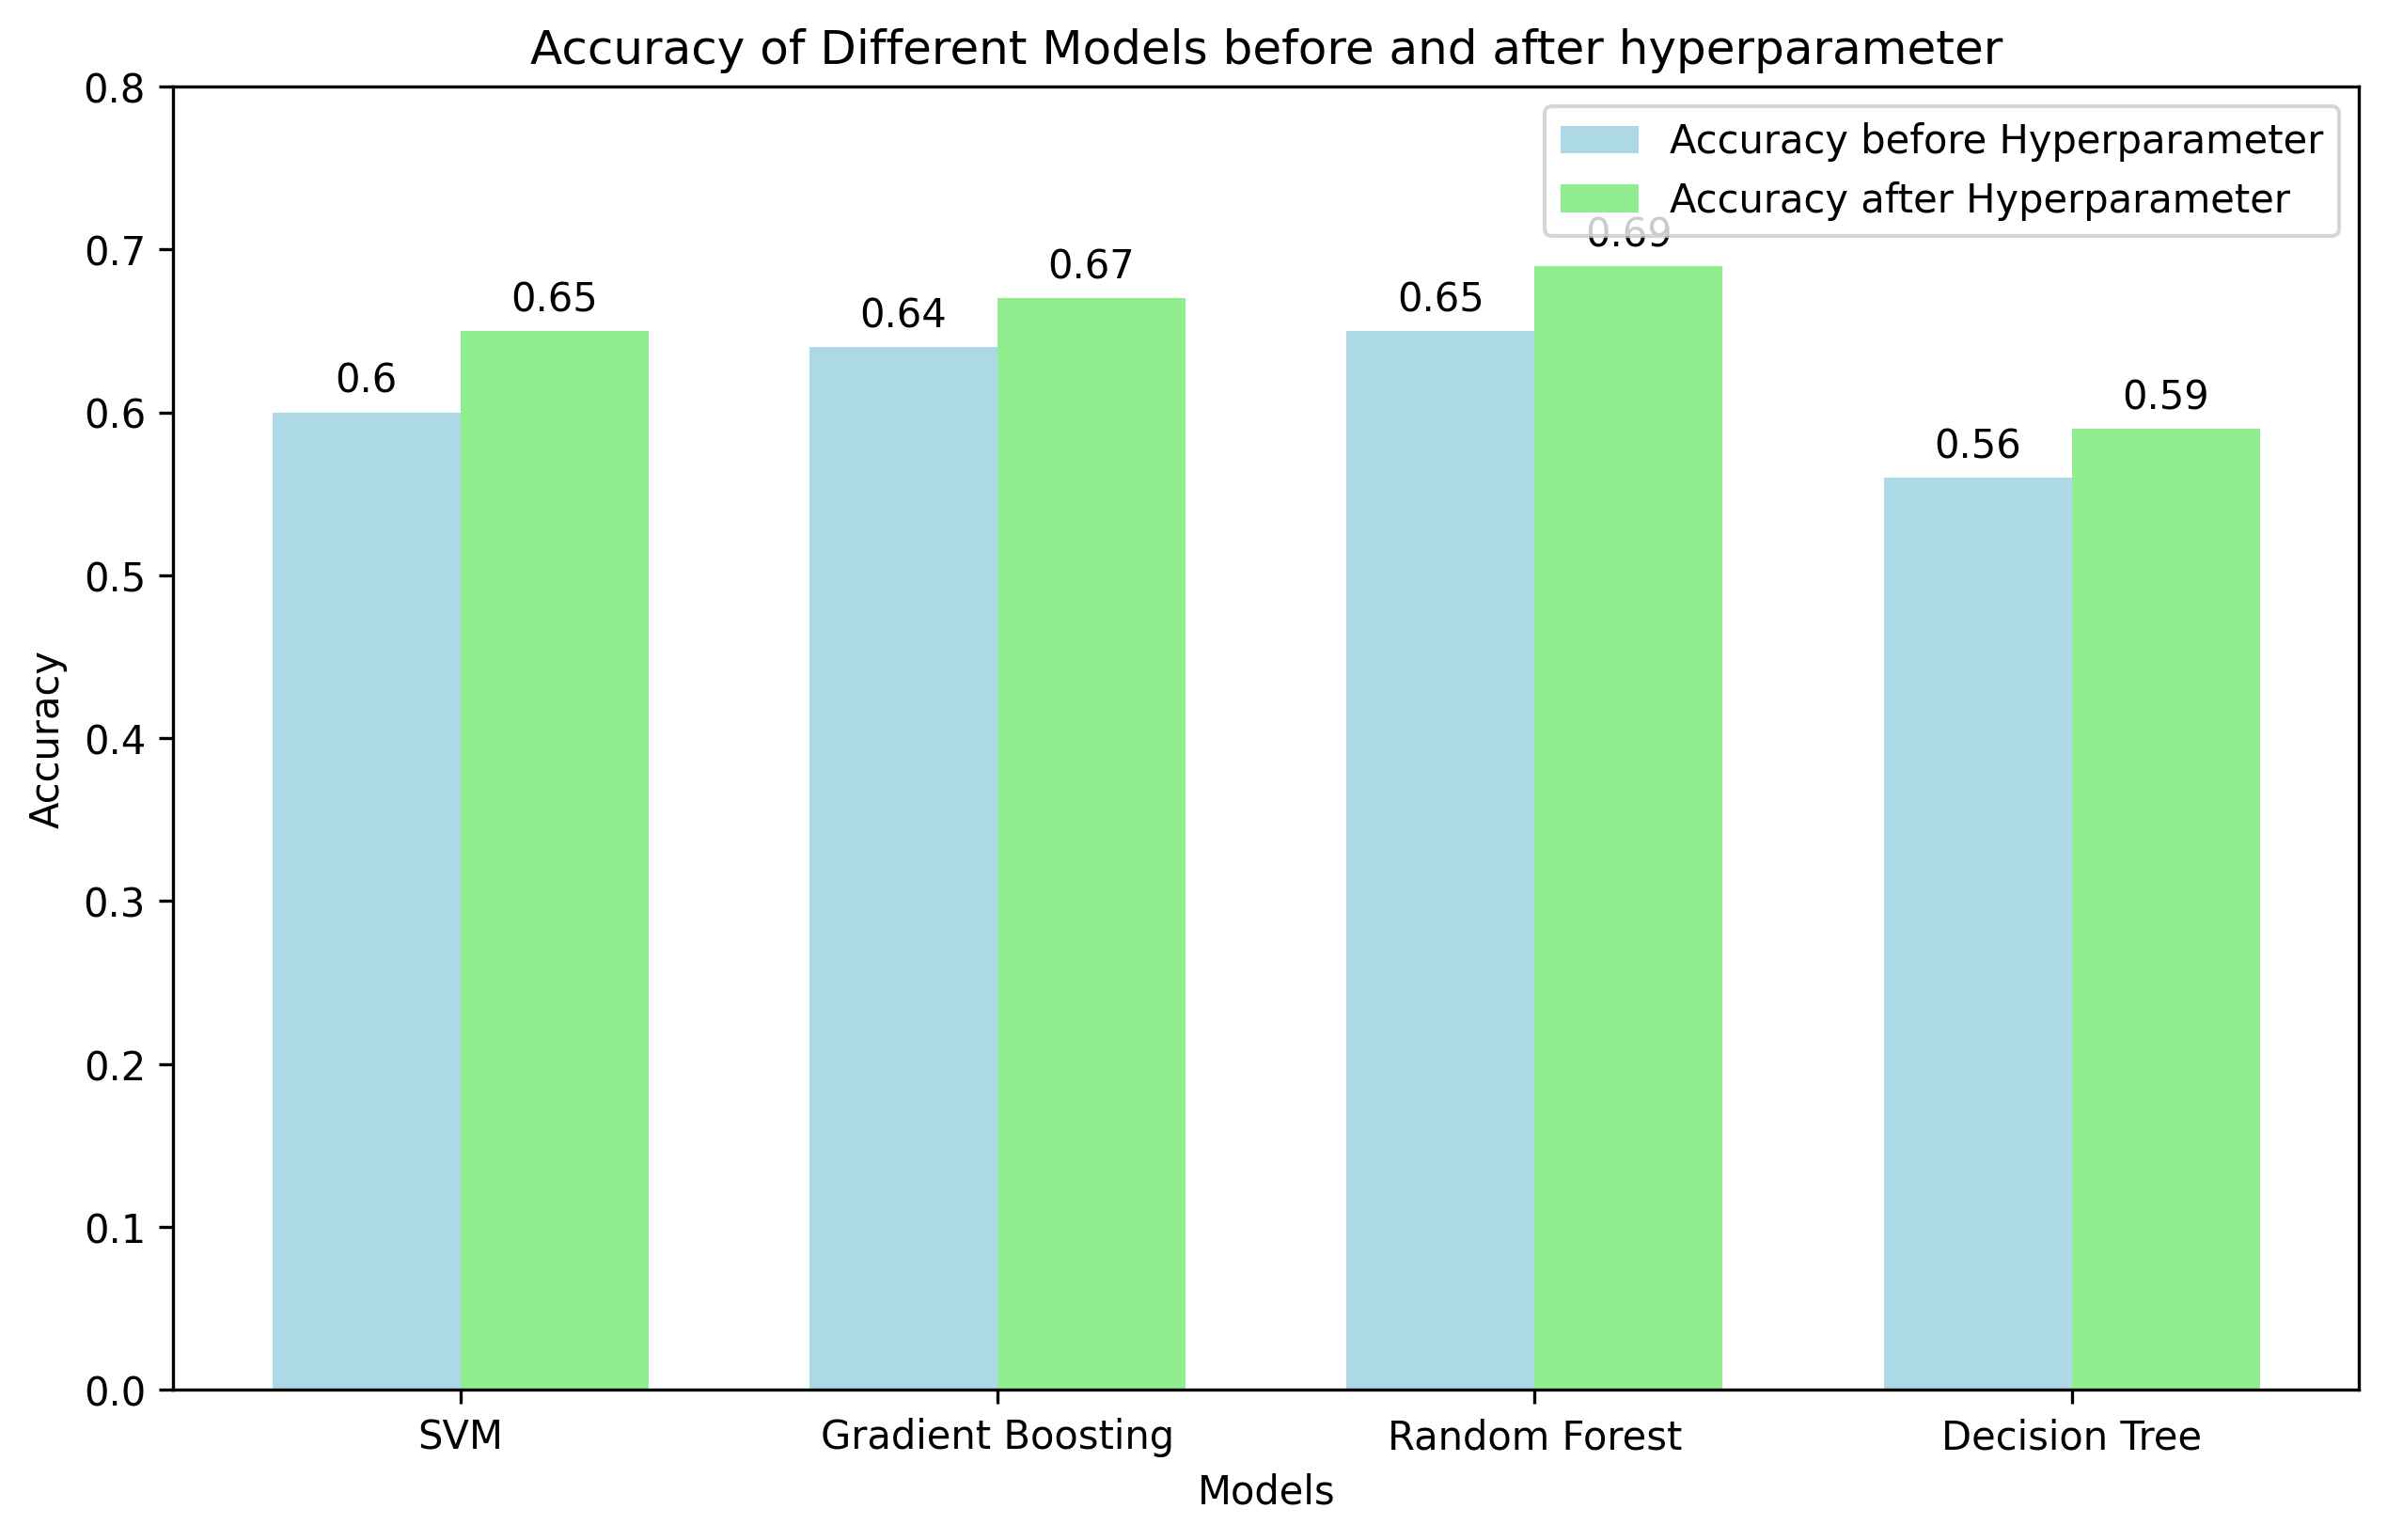

In [8]:
#plot
models_results_beforehy = {
    'SVM': 0.60,
    'Gradient Boosting': 0.64,
    'Random Forest': 0.65,
    'Decision Tree': 0.56
}

models_results_afterhy = {
    'SVM': 0.65,
    'Gradient Boosting': 0.67,
    'Random Forest': 0.69,
    'Decision Tree': 0.59
}


models = list(models_results_beforehy.keys())


acc = list(models_results_beforehy.values())
tuned_acc = list(models_results_afterhy.values())
x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
bars1 = ax.bar(x - width/2, acc, width, label='Accuracy before Hyperparameter', color='lightblue')
bars2 = ax.bar(x + width/2, tuned_acc, width, label='Accuracy after Hyperparameter', color='lightgreen')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Different Models before and after hyperparameter')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)
plt.ylim(0, 0.8)
plt.show()